# Assigment 2 

In this assigment we will work on a regression algorithm for predicting the stock price on a specific date.
We will use the TSLA stock price dataset from Yahoo Finance (Yahoo Finance, 2021).

# Imports

In [19]:
%matplotlib inline

import pandas as pd
import seaborn as sns
import pickle
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split

# Read data from csv


In [20]:
df = pd.read_csv("../data/TSLA-2018.csv")  # Read from file, (comma is the default)
df.head()  # Get an overview of the dataset

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,20.799999,21.474001,20.733334,21.368668,21.368668,65283000
1,2018-01-03,21.400000,21.683332,21.036667,21.150000,21.150000,67822500
2,2018-01-04,20.858000,21.236668,20.378668,20.974667,20.974667,149194500
3,2018-01-05,21.108000,21.149332,20.799999,21.105333,21.105333,68868000
4,2018-01-08,21.066668,22.468000,21.033333,22.427334,22.427334,147891000


## Find out what the types of the values are

In [21]:
# Check if we have any null values in our dataset
print(f"Any null values? {df.isnull().values.any()}")
df.info()  # Check the types for values

Any null values? False
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1466 entries, 0 to 1465
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1466 non-null   object 
 1   Open       1466 non-null   float64
 2   High       1466 non-null   float64
 3   Low        1466 non-null   float64
 4   Close      1466 non-null   float64
 5   Adj Close  1466 non-null   float64
 6   Volume     1466 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 80.3+ KB


We can see that the date column is not recognised, we need to convert it to the right type

## Clean and convert the data

In [22]:
df['Date'] = pd.to_datetime(df['Date'])  # Convert from string to datetime
#df = df.set_index('Date')  # Set the date to be the index 
print(df.head())

        Date       Open       High        Low      Close  Adj Close     Volume
0 2018-01-02  20.799999  21.474001  20.733334  21.368668  21.368668   65283000
1 2018-01-03  21.400000  21.683332  21.036667  21.150000  21.150000   67822500
2 2018-01-04  20.858000  21.236668  20.378668  20.974667  20.974667  149194500
3 2018-01-05  21.108000  21.149332  20.799999  21.105333  21.105333   68868000
4 2018-01-08  21.066668  22.468000  21.033333  22.427334  22.427334  147891000


## See correlations if any

<Axes: >

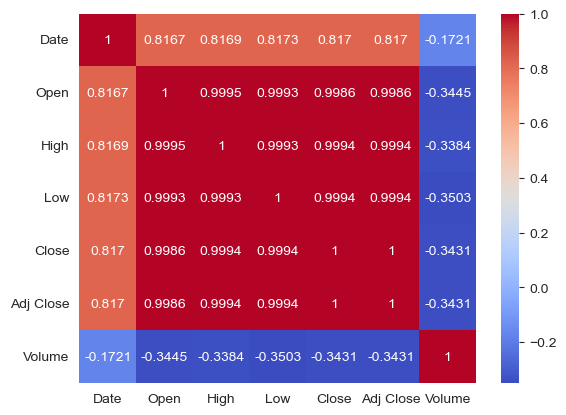

In [23]:
sns.heatmap(df.corr(), annot=True, fmt=".4g", cmap="coolwarm")  #Seaborn plot


We can see that Close and Adj Close is the same ^

In [24]:
df = df.drop(['Adj Close'], axis='columns')  # Drop the 'Adj Close' column

### Visualize the data

Text(0.5, 1.0, 'TSLA - Closing price')

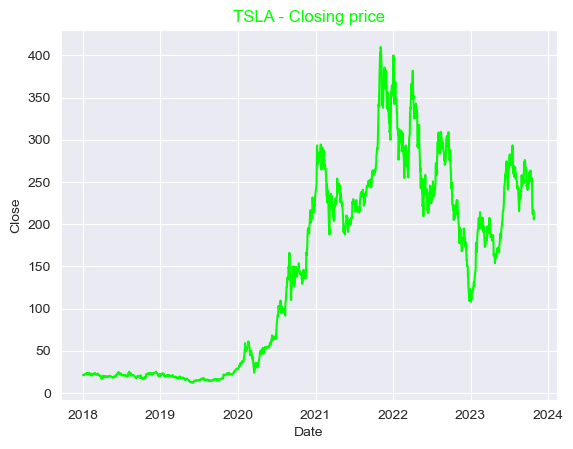

In [25]:
sns.lineplot(df, x='Date', y='Close', color='lime')
plt.title("TSLA - Closing price", color='lime')

Text(0.5, 1.0, 'TSLA - Volume')

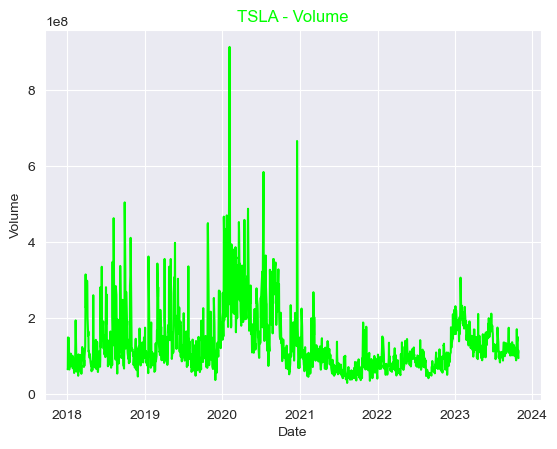

In [26]:
sns.lineplot(df, x='Date', y='Volume', color='lime')
plt.title("TSLA - Volume", color='lime')

### Check distribution using boxplots

Text(0.5, 1.0, 'TSLA - Distribution of closing price ')

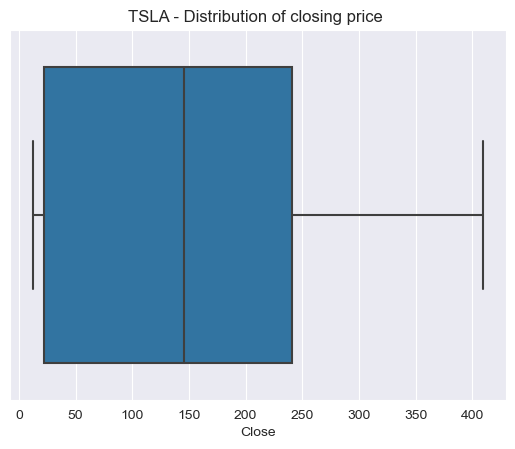

In [27]:
sns.boxplot(df, x='Close')
plt.title("TSLA - Distribution of closing price ")

We can observe outliers significantly distant from the upper quartiles, to fix this we can remove the outliers that fall outside the top 75 % and lower 25 % 

## Remove outliers

In [28]:
# Calculate the IQR for closing price
Q1 = df['Close'].quantile(0.25)  # Lower half
Q3 = df['Close'].quantile(0.75)  # Upper half
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove rows outside the bounds
df = df[(df['Close'] >= lower_bound) & (df['Close'] <= upper_bound)]

### Check distribution after removing outliers

Text(0.5, 1.0, 'TSLA - Distribution of closing price after removing outliers')

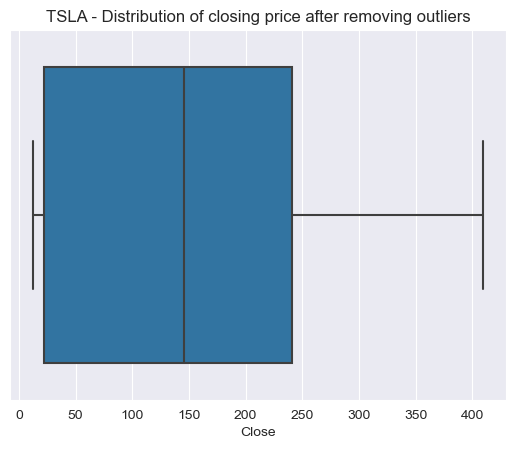

In [29]:
sns.boxplot(df, x='Close')
plt.title("TSLA - Distribution of closing price after removing outliers")

We can see now that the distribution is much better, we only have some outliers. 

### Visualize the data after removing outliers

Text(0.5, 1.0, 'TSLA - Closing price')

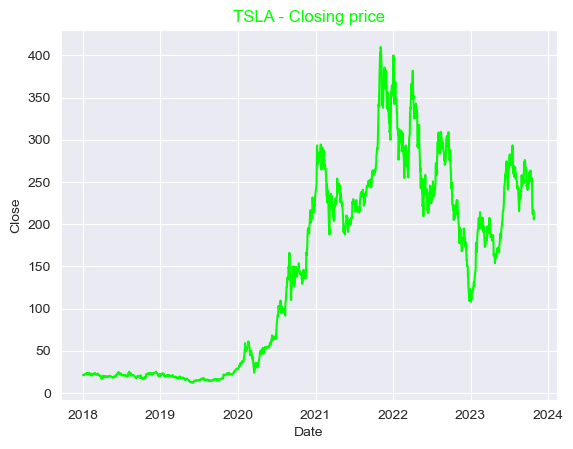

In [30]:
sns.lineplot(df, x='Date', y='Close', color='lime')
plt.title("TSLA - Closing price", color='lime')

Text(0.5, 1.0, 'TSLA - Volume')

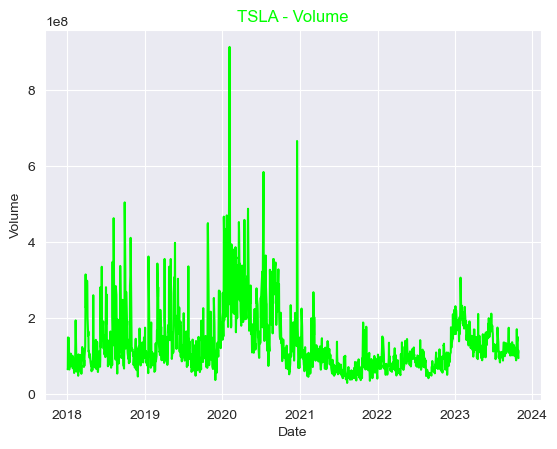

In [31]:
sns.lineplot(df, x='Date', y='Volume', color='lime')
plt.title("TSLA - Volume", color='lime')

## Train the model

### Splitting the training and testing set

In [32]:
X = pd.DataFrame(df['Date'])  #Date
y = pd.DataFrame(df['Close'])  #Close

# Split the data into training/testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

In [33]:
### Save the model

In [34]:
test_degrees = 5  # Try different degrees of polynomial features
mse_degrees = []  # Create a list to store the MSE for each degree

# Loop through the degrees and fit the model, this is to find the best degree
for test_degrees in range(test_degrees):
    # Create polynomial features for the training and testing set
    polynomial_features = PolynomialFeatures(degree=test_degrees)  # Create polynomial features
    x_poly = polynomial_features.fit_transform(X_train)  # Fit and transform the training set
    x_poly_test = polynomial_features.fit_transform(X_test)  # Fit and transform the testing set

    # Train the model
    model = LinearRegression()  # Create a linear regression object
    model.fit(x_poly, y_train)  # Fit the model using the training set
    y_poly_pred = model.predict(x_poly_test)  # Predict the values for the testing set

    # Calculate the MSE on the testing set
    mse = metrics.mean_squared_error(y_test, y_poly_pred)
    mse_degrees.append((mse, test_degrees))  # Add the MSE and degree to the list 
    print(f"MSE = {mse} for degree = {test_degrees}")

# Sort the list of MSE to find the best degree
mse_degrees.sort()

# Get the best degree from the list
best_degree = mse_degrees[0][1]

print(f"Best degree {best_degree}")

# Train the model with the best degree we found again

# Create polynomial features for the training and testing set
polynomial_features = PolynomialFeatures(degree=best_degree)  # Create polynomial features
x_poly = polynomial_features.fit_transform(X_train)  # Fit and transform the training set
x_poly_test = polynomial_features.fit_transform(X_test)  # Fit and transform the testing set

# Train the model
model = LinearRegression()  # Create a linear regression object
model.fit(x_poly, y_train)  # Fit the model using the training set
y_poly_pred = model.predict(x_poly_test)  # Predict the values for the testing set

# Calculate the MSE on the testing set
mse = metrics.mean_squared_error(y_test, y_poly_pred)
print(f"MSE = {mse} for degree = {best_degree}")

MSE = 13549.966474953068 for degree = 0
MSE = 4772.636361630205 for degree = 1
MSE = 4822.742766966362 for degree = 2
MSE = 4879.038926666749 for degree = 3
MSE = 4941.331495777418 for degree = 4
Best degree 1
MSE = 4772.636361630205 for degree = 1


In [35]:
# Save the model and polynomial features to file
pickle.dump(model, open('model.sav', 'wb'))
pickle.dump(polynomial_features, open('poly.sav', 'wb'))

### Visualize the data

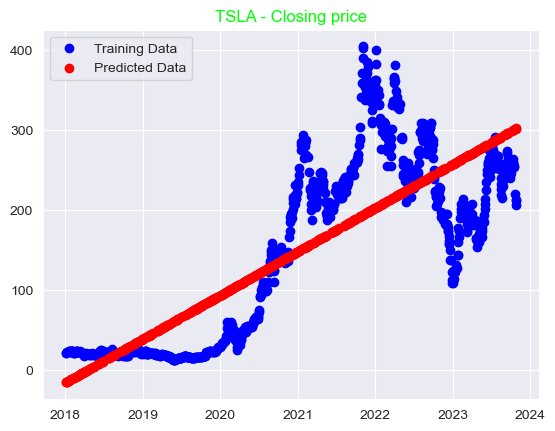

MSE = 4772.636361630205


In [36]:
plt.scatter(X_train, y_train, label='Training Data', color='blue')
plt.scatter(X_test, y_poly_pred, label='Predicted Data', color='red')
plt.title("TSLA - Closing price", color='lime')
plt.legend()
plt.show()

print("MSE = " + str(mse))